In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import optuna

In [53]:
df = pd.read_csv('data/data_featured.csv', sep=';', encoding='utf-8')
df = df.drop(columns='Unnamed: 0').dropna()

X = df.drop(columns=['SiteEnergyUseWN(kBtu)','TotalGHGEmissions'])
y = df['SiteEnergyUseWN(kBtu)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

In [ ]:
models = ["Ridge", "Lasso", "ElasticNet", "SVR", "RandomForest", "GradientBoosting", "XGBoost"]

results = []

for model_name in models:
    
    def objective(trial):
        if model_name == "Ridge":
            alpha = trial.suggest_loguniform("alpha", 1e-3, 1e3)
            model = Ridge(alpha=alpha, max_iter=10000)
        elif model_name == "Lasso":
            alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
            model = Lasso(alpha=alpha, max_iter=10000)
        elif model_name == "ElasticNet":
            alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
            l1_ratio = trial.suggest_uniform("l1_ratio", 0.0, 1.0)
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
        elif model_name == "SVR":
            C = trial.suggest_loguniform("C", 0.1, 1000)
            epsilon = trial.suggest_uniform("epsilon", 0.01, 1)
            kernel = trial.suggest_categorical("kernel", ["rbf", "poly"])
            model = SVR(C=C, epsilon=epsilon, kernel=kernel)
        elif model_name == "RandomForest":
            n_estimators = trial.suggest_int("n_estimators", 100, 800)
            max_depth = trial.suggest_int("max_depth", 3, 50)
            min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
            min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
            max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_features=max_features,
                random_state=42
            )
        elif model_name == "GradientBoosting":
            n_estimators = trial.suggest_int("n_estimators", 100, 500)
            learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
            max_depth = trial.suggest_int("max_depth", 3, 7)
            subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
            model = GradientBoostingRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=subsample,
                random_state=42
            )
        elif model_name == "XGBoost":
            n_estimators = trial.suggest_int("n_estimators", 100, 500)
            learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
            max_depth = trial.suggest_int("max_depth", 3, 10)
            subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
            colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)
            model = XGBRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                random_state=42,
                objective='reg:squarederror'
            )
        
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model)
        ])
        
        pipe.fit(X_train, y_train)
        return pipe.score(X_test, y_test)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30, n_jobs=1, show_progress_bar=True)
    
    results.append({
        "Model": model_name,
        "BestParams": study.best_params,
        "R2": study.best_value
    })

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)


In [59]:
results_df

,Model,BestParams,R2
6,XGBoost,"{'n_estimators': 278, 'learning_rate': 0.04936...",0.810701
5,GradientBoosting,"{'n_estimators': 166, 'learning_rate': 0.10400...",0.809994
0,Ridge,{'alpha': 3.7244483481796085},0.798601
2,ElasticNet,"{'alpha': 0.001751172396827389, 'l1_ratio': 0....",0.798114
1,Lasso,{'alpha': 0.00029349430287285537},0.794754
3,SVR,"{'C': 2.438225019739108, 'epsilon': 0.01166034...",0.793085
4,RandomForest,"{'n_estimators': 779, 'max_depth': 19, 'min_sa...",0.774959


In [ ]:
best_params_XGB = {'n_estimators': 278, 'learning_rate': 0.049363337202518655, 'max_depth': 5, 'subsample': 0.8074365527679774, 'colsample_bytree': 0.7676921911647502}

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

model_XGB = XGBRegressor(**best_params_XGB)
model_XGB.fit(X_train_trans, y_train)

R²   : 0.8055
RMSE : 0.5881
MAE  : 0.4355


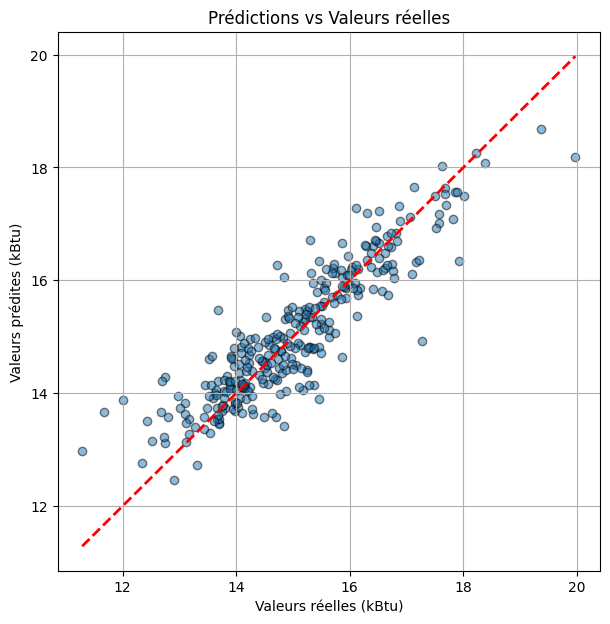

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model_XGB.predict(X_test_trans)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R²   : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Valeurs réelles (kBtu)")
plt.ylabel("Valeurs prédites (kBtu)")
plt.title("Prédictions vs Valeurs réelles")
plt.grid(True)
plt.show()

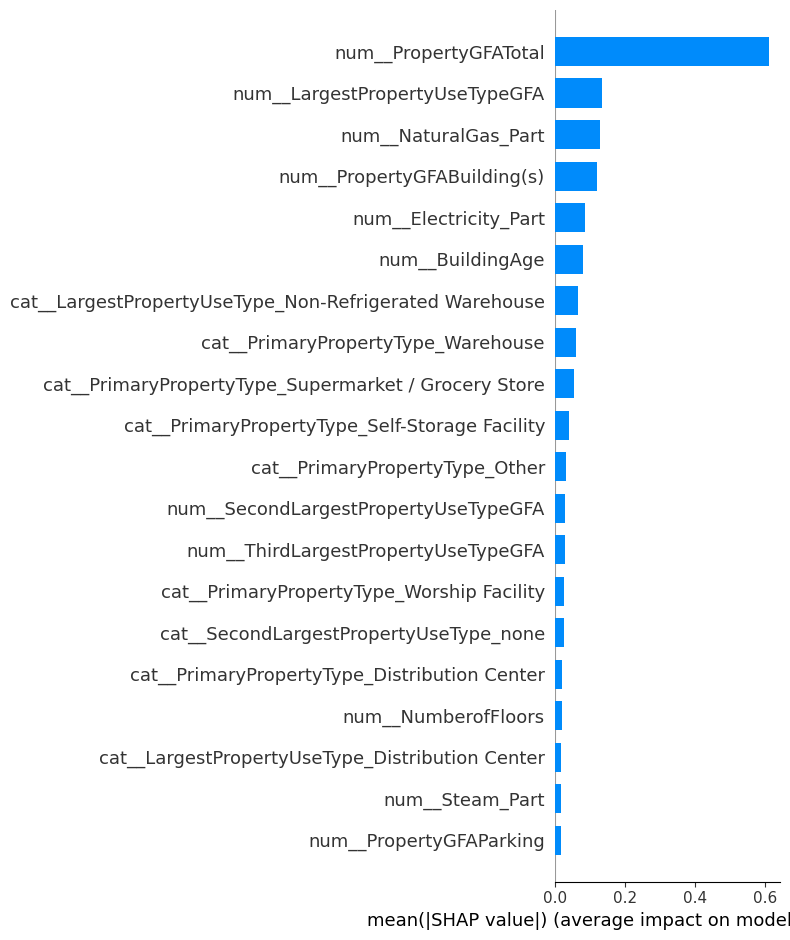

In [45]:
import shap

explainer = shap.Explainer(model_XGB)
shap_values = explainer.shap_values(X_test_trans)

feature_names = preprocessor.get_feature_names_out()

shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names, plot_type="bar")

In [46]:
top_feature = ['PropertyGFATotal', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'Electricity_Part', 'NaturalGas_Part', 'BuildingAge']

In [47]:
preprocessor_light = ColumnTransformer([
    ("num", StandardScaler(), top_feature)
])

In [ ]:
X_train_top_feature = preprocessor_light.fit_transform(X_train)

model_XGB_light = XGBRegressor(**best_params_XGB)
model_XGB_light.fit(X_train_top_feature, y_train)

In [49]:
import bentoml

pipeXGB_light = Pipeline([
    ("preprocessor", preprocessor_light),
    ("model", model_XGB_light)
])

pipeXGB_light.fit(X_train, y_train)

bentoml.sklearn.save_model("energy_consumption_model_light", pipeXGB_light)

Model(tag="energy_consumption_model_light:epy5jnmee2j44aav", path="/tmp/bentoml-model-energy_consumption_model_light-8k_iozzz")

In [50]:
pipeXGB = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model_XGB)
])

pipeXGB.fit(X_train, y_train)

bentoml.sklearn.save_model("energy_consumption_model_full", pipeXGB)

Model(tag="energy_consumption_model_full:erg6fbuee2ljkaav", path="/tmp/bentoml-model-energy_consumption_model_full-ztqs__vr")